In [150]:
from bs4 import BeautifulSoup
from selenium import webdriver
import selenium
from urllib.parse import  urlparse
import time
import lxml
from urllib.request import urlopen
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
import re
import pickle
from contextlib import suppress

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [72]:
xia = pd.read_csv("C:/690009/TP2/final_project/member/NTJ/crawlerNSstar/data/PP/xia.csv")
xia

xia.drop_duplicates(subset=['내용'], inplace=True)
xia

xia["label"] = 0
xia

,Unnamed: 0,내용,별점,label
0,0,쓰던 삼성폰이 갑자기 먹통이 되서 구입하게 되었습니다. 왜 안되는지 알수가 없다네요...,5,0
1,1,자급제폰으로 검색을 하던중에 아무리 둘러봐도 홍미노트7만한 녀석이 없더군요..해외직...,5,0
2,2,"홍미노트6 쓰다가 7을 사 봤습니다.작아진 후면 카메라 부분, 화질은 더욱 좋아졌고...",5,0
3,3,솔직히 말해서 포인트 받을려고 쓰는 거 보다 제품이 너무 좋아서 쓰는 것도 있지만 ...,5,0
4,4,배송도 빠르고 알뜰폰 사용중이라 공기계만 필요했는데 가성비도 좋고 폰도 이쁘고 너무...,5,0
...,...,...,...,...
6966,6966,쓰기편한데 고무라서 그런지 얼마 안가 다시 사야할거같은 느낌적인느낌이들고 그래도 잘...,1,0
6967,6967,상품평을 많은 기대를 갖고서 구입했으나 전화 수신시 알려만주고 번호는 나타나지 않으...,1,0
6968,6968,금액대비 아주 좋습니다 여러모로 편리하네요 감사합니다 저렴하게 잘 산것 같아요,1,0
6969,6969,일주일 걸림,1,0


In [121]:
# xia.set_index("Unnamed: 0", inplace=True)
xia.loc[xia["별점"] > 3.5, "label"] = 1
xia

,내용,별점,label
Unnamed: 0,,,
0,쓰던 삼성폰이 갑자기 먹통이 되서 구입하게 되었습니다. 왜 안되는지 알수가 없다네요...,5,1
1,자급제폰으로 검색을 하던중에 아무리 둘러봐도 홍미노트7만한 녀석이 없더군요..해외직...,5,1
2,"홍미노트6 쓰다가 7을 사 봤습니다.작아진 후면 카메라 부분, 화질은 더욱 좋아졌고...",5,1
3,솔직히 말해서 포인트 받을려고 쓰는 거 보다 제품이 너무 좋아서 쓰는 것도 있지만 ...,5,1
4,배송도 빠르고 알뜰폰 사용중이라 공기계만 필요했는데 가성비도 좋고 폰도 이쁘고 너무...,5,1
...,...,...,...
6966,쓰기편한데 고무라서 그런지 얼마 안가 다시 사야할거같은 느낌적인느낌이들고 그래도 잘...,1,0
6967,상품평을 많은 기대를 갖고서 구입했으나 전화 수신시 알려만주고 번호는 나타나지 않으...,1,0
6968,금액대비 아주 좋습니다 여러모로 편리하네요 감사합니다 저렴하게 잘 산것 같아요,1,0


In [123]:
train_data = xia

In [125]:
train_data.drop_duplicates(subset=["내용"], inplace=True)
len(train_data)

6133

<AxesSubplot:>

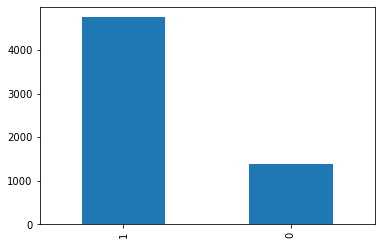

In [126]:
train_data['label'].value_counts().plot(kind = 'bar')

In [127]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   1383
1      1   4750


In [128]:
print(train_data.isnull().values.any())

True


In [129]:
print(train_data.isnull().sum())

내용       1
별점       0
label    0
dtype: int64


In [131]:
train_data.loc[train_data.내용.isnull()]

,내용,별점,label
Unnamed: 0,,,
4502,NaN,3,0


In [132]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [133]:
print(len(train_data))

6132


In [134]:
train_data['내용'] = train_data['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-134-388f03bd8969>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['내용'] = train_data['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-134-388f03bd8969>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['내용'] = train_data['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,내용,별점,label
Unnamed: 0,,,
0,쓰던 삼성폰이 갑자기 먹통이 되서 구입하게 되었습니다 왜 안되는지 알수가 없다네요 ...,5,1
1,자급제폰으로 검색을 하던중에 아무리 둘러봐도 홍미노트만한 녀석이 없더군요해외직구를 ...,5,1
2,홍미노트 쓰다가 을 사 봤습니다작아진 후면 카메라 부분 화질은 더욱 좋아졌고 후면이...,5,1
3,솔직히 말해서 포인트 받을려고 쓰는 거 보다 제품이 너무 좋아서 쓰는 것도 있지만 ...,5,1
4,배송도 빠르고 알뜰폰 사용중이라 공기계만 필요했는데 가성비도 좋고 폰도 이쁘고 너무...,5,1


In [136]:
train_data['내용'] = train_data['내용'].str.replace('^ +', "")
train_data['내용'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

내용       17
별점        0
label     0
dtype: int64


<ipython-input-136-c691e3f2cf46>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['내용'] = train_data['내용'].str.replace('^ +', "")
<ipython-input-136-c691e3f2cf46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['내용'] = train_data['내용'].str.replace('^ +', "")
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [139]:
train_data.loc[train_data.내용.isnull()][:5]

,내용,별점,label
Unnamed: 0,,,


In [138]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

6115


In [140]:
stopwords = ['가','게','고','과','네','는','다','도','들','듯','를','에','와','으로',
             '은','을','의','이','인','임','자','잘','좀','지','하다','한']

In [153]:
okt = Okt()

SystemError: java.lang.UnsatisfiedLinkError: Native Library C:\ProgramData\Anaconda3\Lib\site-packages\_jpype.cp38-win_amd64.pyd already loaded in another classloader